In [7]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer



In [8]:
# Reading the data file into a DATAFRAME and checking the shape
data=pd.read_csv('/content/AmazonMobileDataUncleaned.csv')
print(data.shape)

(71922, 2)


In [10]:
import nltk
nltk.download('stopwords')


def datapreprocess(sen):

    sen = re.sub(r"didn't", "did not", sen)
    sen = re.sub(r"don't", "do not", sen)
    sen = re.sub(r"won't", "will not", sen)
    sen = re.sub(r"can't", "can not", sen)
    sen = re.sub(r"wasn't", "do not", sen)
    sen = re.sub(r"\'ve", " have", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"\'ll", " will", sen)
    sen = re.sub(r"\'re", " are", sen)
    sen = re.sub(r"\'s", " is", sen)
    sen = re.sub(r"\'d", " would", sen)
    sen = re.sub(r"\'t", " not", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"n\'t", " not", sen)

    p = set(string.punctuation) # p take all the punctuations, punctuations displayed below
    sen=sen.lower() # convert text to lower case
    words=sen.split() # split the text into words
    ctext=[]
    for i in range(10): #adding numbers from 0 - 9 to p
        p.add(str(i))
    for i in words:
        t=''.join([x for x in i.encode("ascii","ignore").decode("ascii") if x not in p]) # ignoring non ascii charecters and numbers
        ctext.append(t)
    return " ".join([i for i in ctext]) # joining the cleaned words to text



stop=set(stopwords.words('english'))
print(stop)
stop.remove('no')
stop.remove('not')
stop.remove('nor')

preprocessed_essays = []
for sentance in data['uncleanedreview'].values:
    try:
        ctxt=datapreprocess(str(sentance))
        if len(ctxt)==0: raise()
        ctxt = ' '.join(e for e in ctxt.split() if e not in stop)
        preprocessed_essays.append(ctxt.lower().strip())
    except:
        preprocessed_essays.append("NAN")
data['cleanedtext'] = preprocessed_essays
data.drop(data[data["cleanedtext"]=="NAN"].index,axis = 0,inplace = True) # deleting rows that have no text
data=data.reset_index(drop='true') # after deleting rows index should be reset
data['decision']= data['decision'].replace('positive',1)
data['decision']= data['decision'].replace('negative',0)


s = SnowballStemmer("english")
p=[]
for i in data['cleanedtext'].values:
    k=[]
    for word in i.split():
        k.append(s.stem(word))
    l=' '.join(k)
    p.append(l)

data['j']=p

data.to_csv (r'AmazonMobileDataCleaned.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


{'into', 'under', 'theirs', 'above', 'doesn', "mustn't", 'and', 'to', 'once', 'y', "it's", 'while', 'should', 'yourselves', 'if', 'her', 'why', 'you', 'did', 'will', 'himself', 'than', 'needn', "needn't", 'from', 'do', "mightn't", 'nor', "aren't", 'm', "shouldn't", 'ma', 'hadn', 'we', 'been', 'ourselves', 'he', 'were', 'is', 'no', 'below', 'can', 'during', 'up', 'your', 'mightn', 'have', 'how', 'these', 'me', 'them', "wouldn't", "doesn't", 'a', 'each', 'couldn', 'few', 'this', 'had', 'being', 'as', 'are', 'all', 'o', 'whom', 'until', 'more', 'herself', 'mustn', "hadn't", 'myself', 'too', 'of', 'or', 'on', 'so', 'same', 'after', 'they', 'just', 'about', 'it', 'now', "you're", 'over', 'there', 'my', 'between', 'not', 's', 'aren', 'own', 'themselves', 'itself', 'an', 'at', 'out', 'wouldn', 'what', 'doing', 'those', 'other', 'ain', 'its', 'does', 'before', 'don', 'such', 'weren', 'won', "you've", 'through', 're', 've', 'where', 't', 'their', 'both', "wasn't", 'having', "you'd", 'but', 'tha

In [11]:
data=pd.read_csv('AmazonMobileDataCleaned.csv',nrows=5000)
print(data.shape)
label = data['decision'].values
feedback = data.drop(['decision'], axis=1)
print(label.shape)
print(feedback.shape)
print("------------------------------")

from sklearn.model_selection import train_test_split
inputtrain, inputtest, outputtrain, outputtest = train_test_split(feedback, label, test_size=0.20, stratify=label)
print(inputtrain.shape)
print(inputtest.shape)
print(outputtrain.shape)
print(outputtest.shape)

(5000, 5)
(5000,)
(5000, 4)
------------------------------
(4000, 4)
(1000, 4)
(4000,)
(1000,)


In [14]:
# convert into Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
featur = []
vec = CountVectorizer(min_df=10,ngram_range=(1,2))
vec.fit(inputtrain['j'].values) # fit has to happen only on train data


train_cleanedtext = vec.transform(inputtrain['j'].values)
test_cleanedtext= vec.transform(inputtest['j'].values)

print("After vectorizations")
print(train_cleanedtext.shape)
print(test_cleanedtext.shape)
print(outputtrain.shape)
print(outputtest.shape)
print("...............................")

features = vec.get_feature_names_out()

After vectorizations
(4000, 2783)
(1000, 2783)
(4000,)
(1000,)
...............................


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingClassifier

# Initializing models
train_cleanedtext1=train_cleanedtext.toarray()
clf1 = KNeighborsClassifier()
clf2 = RandomForestClassifier()
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          meta_classifier=lr)

params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf,
                    param_grid=params,
                    cv=5,
                    refit=True)
grid.fit(train_cleanedtext1, outputtrain)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)


0.823 +/- 0.00 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.832 +/- 0.00 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.765 +/- 0.01 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.829 +/- 0.00 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.830 +/- 0.00 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.847 +/- 0.00 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.838 +/- 0.00 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.854 +/- 0.00 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier_

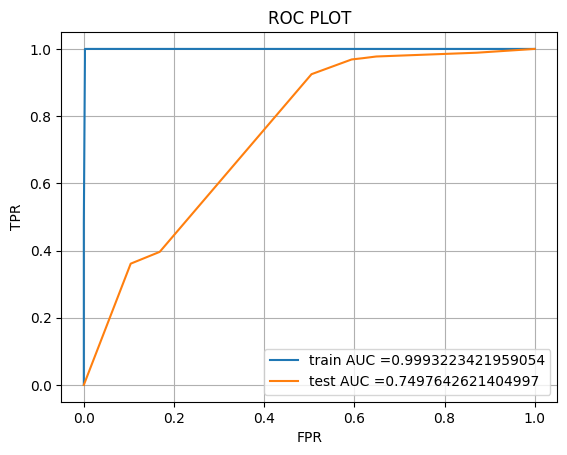

---------------------------------------------------
the maximum value of tpr*(1-fpr) 0.9975308641975309 for threshold 0.996
Train confusion matrix


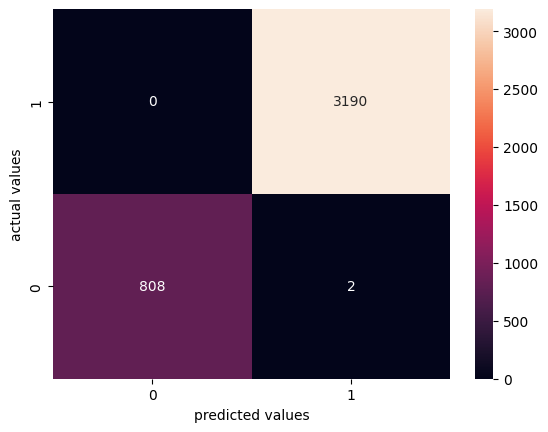

Test confusion matrix


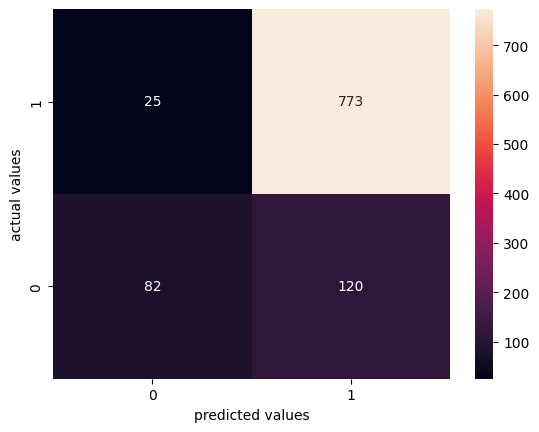

In [16]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

test_cleanedtext1=test_cleanedtext.toarray()

clf1 = KNeighborsClassifier(n_neighbors=5)
clf2 = RandomForestClassifier(n_estimators=50)
clf3 = GaussianNB()
lr = LogisticRegression(C=10.0)
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          meta_classifier=lr)

sclf.fit(train_cleanedtext1, outputtrain)

y_train_pred = sclf.predict_proba(train_cleanedtext1)[:,1]
y_test_pred = sclf.predict_proba(test_cleanedtext1)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(outputtrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(outputtest, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]

    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("---------------------------------------------------")


from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

ax=sns.heatmap(confusion_matrix(outputtrain, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx=sns.heatmap(confusion_matrix(outputtest, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()